In [1]:
__author__ = 'Erwin Chen'
%matplotlib inline
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.io import fits
from astropy.table import Table, join, Column
import numpy as np
from numpy.random import rand
import scipy.stats as stats
from scipy.sparse import lil_matrix
import scipy.spatial.distance as distance
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors, DistanceMetric
from sklearn import mixture, preprocessing
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.cluster import v_measure_score, homogeneity_completeness_v_measure
import cPickle as pickle

In [2]:
def jaccard(a,b):
    """
    Calculate Jaccard distance between two arrays
    Parameters:
    -----------
    a: an array
    b: an array
    """
    A = np.array(a, dtype='int')
    B = np.array(b, dtype='int')
    A = A[np.where(A > -1)[0]]
    B = B[np.where(B > -1)[0]]
    union = np.union1d(A,B)
    intersection = np.intersect1d(A,B)
    return 1.0 - len(intersection)*1.0 / len(union)

In [3]:
def get_friends(data, num_element, n_chem, n_rv):
    """
    Get neartest neighbors in both chemical and radial velocity spaces for every star.
    Parameters:
    -----------
    data: a matrix that contains chemical abundances and radial velocities
    num_element: number of elements in the matrix
    n_chem: number of nearest neighbors in chemical space 
    n_rv: number of nearest neighbors in radial velocity space
    """
    data = np.array(data)
    index_chem = np.arange(0, num_element, 1)
    nbrs_chem = NearestNeighbors(n_neighbors=n_chem, algorithm='ball_tree', metric='manhattan').fit(data[:,index_chem])
    distances_chem, indices_chem = nbrs_chem.kneighbors(data[:,index_chem])
    index_rv = np.arange(num_element, len(data[0]), 1)
    rv_data = np.copy(data[:,index_rv])
    if len(rv_data[0]) < 2:
        rv_data = rv_data.reshape(-1, 1)
    nbrs_rv = NearestNeighbors(n_neighbors=n_rv, algorithm='ball_tree').fit(rv_data)
    distances_rv, indices_rv = nbrs_rv.kneighbors(rv_data)
    indices = []
    for n in range(len(indices_chem)):
        indices.append(np.intersect1d(indices_chem[n], indices_rv[n]))
    indices = np.array(indices)
    return indices

In [4]:
def iterator_dist(indices):
    """
    An iterator that calculates ans stores the Jaccard distance between every two stars
    Parameters:
    -----------
    indices: a list of indices of neighbors for every star
    """
    for n in range(len(indices)):
        for m in range(n+1, len(indices)):
            dist = jaccard(indices[n], indices[m])
            if dist < 1:
                yield (n, m, dist)

In [5]:
## load example dataset
element_names = np.array(['V_H', 'TI_H', 'CA_H','FE_H', 'K_H', 'MN_H', 'NI_H', 'SI_H', 'S_H'])
ap_table = Table.read("example_dataset.csv")
# ap_table = pickle.load(open("example_dataset.p","rb")) 

In [6]:
ap_table

APOGEE_ID,GLON,GLAT,RA,DEC,VHELIO_AVG,LOGG,TEFF,PMRA,PMDEC,AL_H,NA_H,O_H,MG_H,C_H,N_H,V_H,TI_H,CA_H,FE_H,K_H,MN_H,NI_H,SI_H,S_H,SNR,cluster_name,label
str18,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str10,int32
2M00005666+1647445,105.904404447,-44.4001106393,0.236115,16.795702,-23.7415008545,2.8715294931,4773.73131936,-6.19999980927,-9.10000038147,0.0310876399126,-0.0505834542441,-0.0562509748948,-0.132933818897,-0.138534605803,-0.127732381404,-0.575796900918,-0.0929587119829,-0.179256336164,-0.150893812206,-0.207718718232,-0.11609392439,-0.195493113552,-0.00906666934762,0.0841851145521,135.143005371,background,-1
2M00012694+1639052,106.012581468,-44.5717214285,0.362289,16.651464,-73.3161010742,1.40537893446,3990.77909841,211.0,-73.0,-1.54021759857,-2.38119434449,-1.39105364945,-1.41880702745,-1.86242482052,-1.44112638017,-2.3689723296,-1.7798236975,-1.30127067836,-1.77137284977,-1.55960186774,-2.11441771733,-1.90335184939,-1.44241477365,-1.2577370007,125.549003601,background,-1
2M00012984+7052497,118.827240711,8.40794295219,0.37435,70.880486,-93.3716964722,2.52892530342,4720.50823869,6.0,-4.0,0.0105429509999,-0.474391262866,-0.0543582733746,-0.133940022562,-0.137732021751,-0.210047643174,-0.443915958603,-0.0850458336879,-0.326723886977,-0.25330882075,-0.20215311554,-0.25735658152,-0.187665013666,0.0348171397216,0.0640326544529,129.013000488,background,-1
2M00013568+5638516,116.086624386,-5.56003539912,0.398708,56.647671,-88.9654006958,1.26611342744,4127.92040391,0.0,0.0,-0.299780604063,-0.537552128264,-0.206990789484,-0.367487290785,-0.491208368926,-0.116617727264,-0.702416513559,-0.386137933957,-0.396036637034,-0.401351138261,-0.285475038606,-0.337990168455,-0.401043058124,-0.17437511868,-0.252349548498,225.942001343,background,-1
2M00013901+1658396,106.200409563,-44.2704853169,0.412571,16.977688,-3.21912002563,2.70478262076,4816.89820312,-16.0,-24.2999992371,0.204324411053,0.112202098441,0.106522074562,0.0312500568846,0.0300811541743,0.292481863147,0.0354341060213,0.157226965455,0.0169800087507,0.100375038426,-0.0400850833934,0.23252706999,0.122681061779,0.250232199894,0.127239552033,721.568969727,background,-1
2M00015350+6459174,117.72291688,2.6188491138,0.472954,64.988167,-83.3326034546,0.832128201268,3779.16827318,0.0,0.0,-0.189549732255,-0.0172572763789,-0.022246233334,-0.038906088923,-0.0936783342868,0.129901356605,-0.201345356035,-0.138932045045,-0.15420965985,-0.10769482813,-0.0756767966919,0.165611219994,-0.0304030471768,-0.075063219931,0.0598534930044,576.156982422,background,-1
2M00024516+5635133,116.232097836,-5.64993749695,0.688167,56.587036,-17.1861991882,3.76423003039,5639.9298158,-4.0,-10.0,-0.529113872955,-0.199665724564,-0.469594406675,-0.38297762203,-0.174485943998,-0.61443782238,-0.286305608718,-0.563471906644,-0.51764347022,-0.522117160132,-0.623421046862,-0.432371101308,-0.50862384843,-0.3899995443,-0.162409275297,144.152999878,background,-1
2M00035027+7026134,118.934390435,7.93578704033,0.959485,70.437057,-5.9220199585,4.22380923094,5024.74509686,12.0,-4.0,-0.0129889117747,0.0171634425746,7.33988694145e-05,0.0792348663483,0.103159876656,-0.425652860198,0.0533097535637,0.0198684453101,-0.0795691701145,-0.0209522936111,-0.295179950863,0.0663605465456,-0.0365425212517,0.00460125970399,-0.230291078272,100.008003235,background,-1
2M00035120+7551279,119.965803063,13.2609260464,0.96335,75.857765,-58.7495002747,2.98852471066,4942.12990374,0.0,0.0,0.209094739275,-0.0176456055329,0.143748703143,0.0994181509926,0.0170186434697,0.449720252274,-0.0214957953592,0.105349603082,0.109718686088,0.158843591363,-0.0740924868228,0.285979416466,0.195799257335,0.214434611579,0.209588552448,380.403015137,background,-1


In [7]:
## Compile a matrix that contains chemical abundances and radial velocity
Fe_index = np.where(element_names == 'FE_H')[0][0]
chem = [ap_table[element]-ap_table['FE_H'] for element in element_names]
chem[Fe_index] = ap_table['FE_H']
chem.append(ap_table['VHELIO_AVG'])
chem_RV = np.array(chem).T
chem = np.delete(chem_RV,-1,1)
print chem.shape
print chem_RV.shape

(2039L, 9L)
(2039L, 10L)


In [8]:
%%time 
## Get the indices of nearest neighbors in chemical and radial velocity space for every star
indices = get_friends(chem_RV, 9, 150, 50)

Wall time: 268 ms


In [9]:
## find min_samples for DBSCAN
lengths = np.array([len(indices[n]) for n in range(len(indices))])
H, edges = np.histogram(lengths)
print "Number of Stars/ Threshold"
for n in range(len(H)):
    print H[n], edges[n+1]

Number of Stars/ Threshold
902 5.9
867 10.8
143 15.7
31 20.6
6 25.5
10 30.4
17 35.3
24 40.2
23 45.1
16 50.0


In [10]:
## check if known members have sufficient number of neighbors
c_name = "M13"
members = np.where(ap_table['cluster_name'] == c_name)[0]
print lengths[members]

[38 39 50 43 40 32 45 42 36 41 40 42 42  2 37 33 39 33 27 36 38 35 49 33 41
 34 39 37 41 39 44 39 46 44 38 42 40 48 46 48 39 38 45 37 41 43 47 49 45 47
 44 34 47 43 42 50 49 42 39 47 49 35 37 39 45 36 47 31 34 29 46]


In [11]:
## Select stars with more than N_cut number of neighbors
N_cut = 1
non_noise = np.where(lengths > N_cut)[0]
print "%i stars has more than %i neighbors"%(len(non_noise), N_cut)

1981 stars has more than 1 neighbors


In [12]:
%%time

## Get the distance matrix
S = lil_matrix((len(non_noise), len(non_noise)))
for (n, m, dist) in iterator_dist(indices[non_noise]):
    S[n,m] = dist
    S[m,n] = dist

Wall time: 1min 2s


In [13]:
## find eps for DBSCAN
core = np.where(lengths[non_noise] > 11)[0]
S_core = S[core][:,core]
dist = np.array([])
for n in range(len(core)):
    row = S_core[n].todense()
    d = np.asarray(row[row > 0])[0]
    dist = np.append(dist, np.sort(d)[:11])
dist = np.sort(dist)
x = np.arange(len(dist))

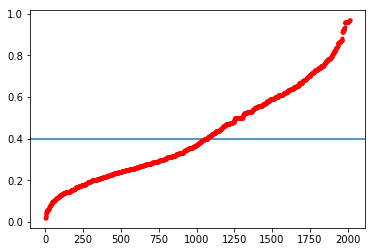

In [14]:
plt.axhline(y=0.4, xmin=0, xmax=1)
plt.plot(x, dist, "r.")
plt.show()

In [15]:
%%time 

## DBSCAN SNN
db = DBSCAN(eps=0.4, min_samples=11, metric='precomputed', n_jobs=-1).fit(S, lengths[non_noise])
labels = db.labels_
n_clumps = np.amax(labels) + 1
true_labels = ap_table["label"][non_noise]
print "%i clusters found"%n_clumps
print "#Categorized as Member/ Ratio of Member: ", 
print len(np.where(labels != -1)[0]), "/", len(np.where(labels != -1)[0])*1.0/len(labels)

2 clusters found
#Categorized as Member/ Ratio of Member:  95 / 0.0479555779909
Wall time: 18 ms


70 members recovered:
84 stars in this group


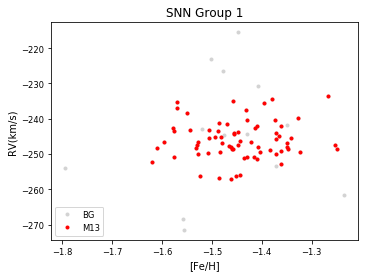

In [16]:
xlab = "[Fe/H]"
ylab = "RV(km/s)"
X = ap_table['FE_H']
Y = ap_table['VHELIO_AVG']
for n in range(max(labels)+1):
    group = non_noise[np.where(labels == n)[0]]
    group_members = np.intersect1d(members, group)
    if len(group_members) > 0:
        print "%i members recovered:"%len(group_members)
        print "%i stars in this group"%len(group)
        fig = plt.figure(figsize=(5.5, 4))
        plt.plot(X[group], Y[group], ".", c="lightgrey", label="BG")
        plt.plot(X[group_members], Y[group_members], ".", c='r', label="M13")
        plt.xlabel(xlab)
        plt.ylabel(ylab)
        plt.xticks(fontsize="small")
        plt.yticks(fontsize="small")
        plt.legend(loc=3, fontsize="small", numpoints=1)
        plt.title("SNN Group %i"%n)
        plt.savefig("SNN_Group_%i.png"%n, dpi=500)
        plt.show()

In [17]:
## KMeans Chemical Tagging
k_num = 3
random_state = 123
kmeans = KMeans(n_clusters=k_num, random_state=random_state, max_iter=200)
kmeans.fit_predict(chem)
km_labels = kmeans.labels_

1 members recovered:
662 stars in this group


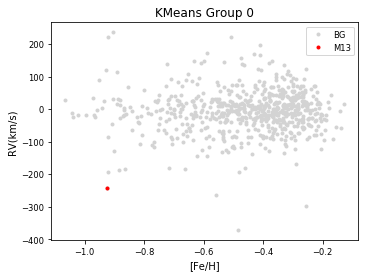

70 members recovered:
503 stars in this group


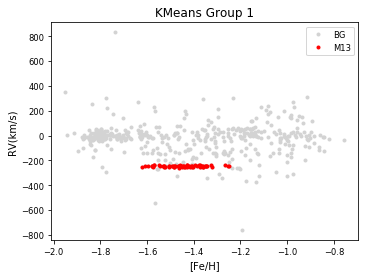

In [18]:
xlab = "[Fe/H]"
ylab = "RV(km/s)"
X = ap_table['FE_H']
Y = ap_table['VHELIO_AVG']
for n in range(max(km_labels)+1):
    group = np.where(km_labels == n)[0]
    group_members = np.intersect1d(members, group)
    if len(group_members) > 0:
        print "%i members recovered:"%len(group_members)
        print "%i stars in this group"%len(group)
        fig = plt.figure(figsize=(5.5, 4))
        plt.plot(X[group], Y[group], ".", c="lightgrey", label="BG")
        plt.plot(X[group_members], Y[group_members], ".", c='r', label="M13")
        plt.xlabel(xlab)
        plt.ylabel(ylab)
        plt.xticks(fontsize="small")
        plt.yticks(fontsize="small")
        plt.legend(loc=0, fontsize="small", numpoints=1)
        plt.title("KMeans Group %i"%n)
        plt.savefig("KMeans Group %i"%n, dpi=500)
        plt.show()

In [19]:
## find eps for DBSCAN
nbrs = NearestNeighbors(n_neighbors=25, algorithm='ball_tree', metric='manhattan').fit(chem)
dist, indices = nbrs.kneighbors(chem)
dist = dist.flatten()
dist = dist[dist > 0]
dist = np.sort(dist)
x = np.arange(len(dist))

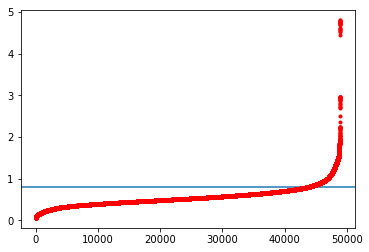

In [20]:
plt.axhline(y=0.8, xmin=0, xmax=1)
plt.plot(x, dist, "r.")
plt.show()

In [21]:
## DBSCAN Chemical Tagging
db = DBSCAN(eps=0.45, min_samples=25, metric='manhattan').fit(chem)
db_labels = db.labels_
print "%i groups found"%len(db_labels)

2039 groups found


57 members recovered:
183 stars in this group


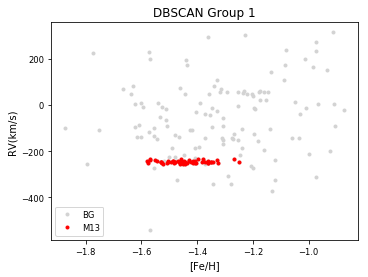

In [22]:
xlab = "[Fe/H]"
ylab = "RV(km/s)"
X = ap_table['FE_H']
Y = ap_table['VHELIO_AVG']
for n in range(max(db_labels)+1):
    group = np.where(db_labels == n)[0]
    group_members = np.intersect1d(members, group)
    if len(group_members) > 0:
        print "%i members recovered:"%len(group_members)
        print "%i stars in this group"%len(group)
        fig = plt.figure(figsize=(5.5, 4))
        plt.plot(X[group], Y[group], ".", c="lightgrey", label="BG")
        plt.plot(X[group_members], Y[group_members], ".", c='r', label="M13")
        plt.xlabel(xlab)
        plt.ylabel(ylab)
        plt.xticks(fontsize="small")
        plt.yticks(fontsize="small")
        plt.legend(loc=0, fontsize="small", numpoints=1)
        plt.title("DBSCAN Group %i"%n)
        plt.savefig("DBSCAN Group %i"%n, dpi=500)
        plt.show()